# Project 3: Neural Network Comparison (Ames Housing)

## 1. Project Objective
This project is an extension of the initial "Ames Housing Price Prediction" assignment. The goal is to compare the performance of our original ensemble model (**Random Forest**) against various **Neural Network architectures** to determine the most effective approach for this regression task.

We will proceed in two main phases:
1.  **Establish a Strong Baseline:** We will optimize our Random Forest model using Hyperparameter Tuning (`RandomizedSearchCV`) to ensure we are comparing against the best possible version of the ensemble model.
2.  **Neural Network Experimentation:** We will build and test four different Neural Network architectures (Simple, Deep, Regularized, and Robust) using TensorFlow/Keras.

## Step 1: Data Preprocessing & Baseline Establishment
In this first step, we load the data and apply a preprocessing pipeline compatible with Neural Networks.
* **Transformation:** The target variable `SalePrice` is log-transformed to normalize its distribution.
* **Scaling:** Unlike Random Forest, Neural Networks require features to be scaled. We apply `StandardScaler` to all numerical inputs.
* **Encoding:** Categorical features are one-hot encoded.

We then train our **Baseline Model**: an **Optimized Random Forest**.
*Note: We previously performed a RandomizedSearchCV to find the optimal hyperparameters (`n_estimators=300`, `min_samples_split=5`), which we apply directly here.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Load Data
df = pd.read_csv("train.csv")
print(f"Data Loaded: {df.shape}")

# 2. Preprocessing Setup (Same as Project 1)
# Log-transform Target
y = np.log1p(df['SalePrice'])
X = df.drop(['Id', 'SalePrice', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

# Split Data (70% Train, 15% Valid, 15% Test)
X_train_raw, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid_raw, X_test_raw, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define Transformers
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

# 3. Transform Data for Neural Networks
# Neural Networks require explicit numpy arrays, not raw DataFrames
print("Preprocessing data...")
X_train = preprocessor.fit_transform(X_train_raw)
X_valid = preprocessor.transform(X_valid_raw)
X_test = preprocessor.transform(X_test_raw)

print(f"Processed Feature Shape: {X_train.shape}")

# 4. Train Baseline: Optimized Random Forest
# Using the parameters you found in your tuning step
print("\nTraining Baseline (Optimized Random Forest)...")
rf_model = RandomForestRegressor(
    n_estimators=300,
    min_samples_split=5,
    min_samples_leaf=2,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Evaluate Baseline
def evaluate_model(model, X_data, y_true, name="Model"):
    y_pred = model.predict(X_data)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))
    print(f"--- {name} Performance ---")
    print(f"R² Score:       {r2:.4f}")
    print(f"RMSE (in $):    {rmse:,.2f}")
    return r2, rmse

base_r2, base_rmse = evaluate_model(rf_model, X_test, y_test, "Optimized Random Forest")

Data Loaded: (1460, 81)
Preprocessing data...
Processed Feature Shape: (1022, 269)

Training Baseline (Optimized Random Forest)...
--- Optimized Random Forest Performance ---
R² Score:       0.9000
RMSE (in $):    30,646.13


## Step 2: Neural Network Experimentation

To properly evaluate Deep Learning on this dataset, we will test architectures of increasing complexity. We also define a helper function `plot_history` to visualize the training and validation loss over epochs, allowing us to diagnose overfitting or underfitting.

### Model 1: Simple Neural Network (Shallow)
Our first experiment is a "Shallow" network with a single hidden layer. This serves as a sanity check to see if a basic perceptron structure can capture the pricing relationships.

* **Architecture:** Input (269 features) -> Dense (64 neurons, ReLU) -> Output (1 neuron)
* **Goal:** Establish a baseline for Neural Network performance.

Building Model 1: Simple NN...
Training Model 1...


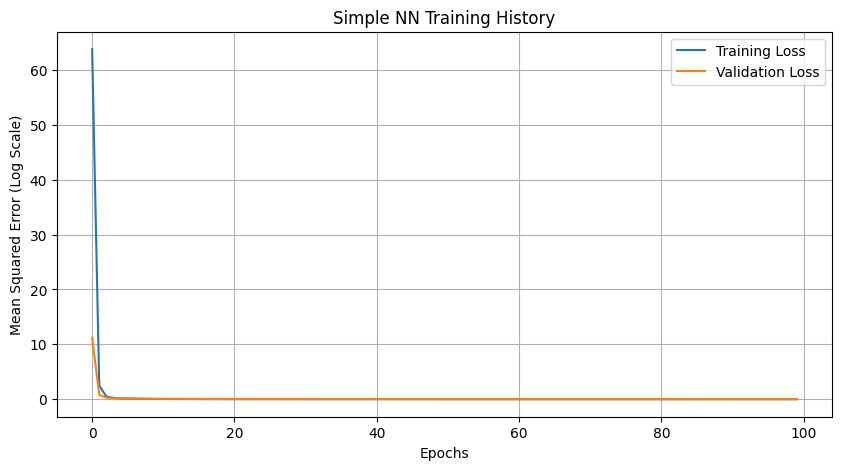

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
--- Model 1 (Simple NN) Performance ---
R² Score:       0.6698
RMSE (in $):    127,143.51


In [2]:
# 1. Helper Function to Plot Loss Curves
def plot_history(history, title="Model Loss"):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (Log Scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. Define Model 1: Simple Neural Network (Shallow)
# Architecture: Input -> Dense(64) -> Output
print("Building Model 1: Simple NN...")
model_1 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer matches feature count (269)
    layers.Dense(64, activation='relu'),      # Single hidden layer
    layers.Dense(1)                           # Output layer (1 value: Price)
])

# 3. Compile
model_1.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# 4. Train
# We train for 100 epochs, but it's fast because the network is small
print("Training Model 1...")
history_1 = model_1.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=32,
    verbose=0 # Hides the epoch-by-epoch log to keep output clean
)

# 5. Evaluate and Plot
plot_history(history_1, title="Simple NN Training History")
r2_m1, rmse_m1 = evaluate_model(model_1, X_test, y_test, "Model 1 (Simple NN)")

### Model 2: Deep Neural Network
Neural Networks typically benefit from depth, allowing them to learn hierarchical representations of the data. For our second model, we increase the capacity by adding two more hidden layers.

* **Architecture:** Input -> Dense(128) -> Dense(64) -> Dense(32) -> Output
* **Hypothesis:** The added depth should allow the model to capture more complex interactions between features (e.g., how "Overall Quality" interacts with "Neighborhood"), potentially improving the $R^2$ score.

Building Model 2: Deep NN...
Training Model 2...


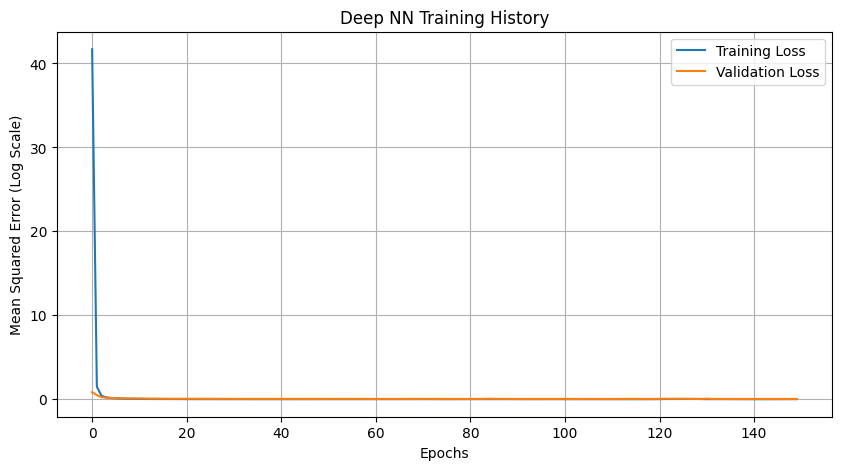

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
--- Model 2 (Deep NN) Performance ---
R² Score:       0.2383
RMSE (in $):    945,035.09


In [3]:
# 1. Define Model 2: Deep Neural Network
# We add more layers to capture complex patterns
print("Building Model 2: Deep NN...")
model_2 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),     # Layer 1: 128 Neurons
    layers.Dense(64, activation='relu'),      # Layer 2: 64 Neurons
    layers.Dense(32, activation='relu'),      # Layer 3: 32 Neurons
    layers.Dense(1)                           # Output
])

# 2. Compile
model_2.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# 3. Train
# We train for slightly longer (150 epochs) to give the deeper network time to learn
print("Training Model 2...")
history_2 = model_2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=150,
    batch_size=32,
    verbose=0
)

# 4. Evaluate and Plot
plot_history(history_2, title="Deep NN Training History")
r2_m2, rmse_m2 = evaluate_model(model_2, X_test, y_test, "Model 2 (Deep NN)")

### Model 3: Regularized Neural Network
Deep networks often suffer from **overfitting**, where the model memorizes the training data but fails to generalize to new houses. To combat this, we introduce regularization techniques:

1.  **Dropout:** Randomly ignores 30% of neurons during training to prevent over-reliance on specific features.
2.  **Early Stopping:** Monitors the validation loss and automatically stops training if the model stops improving, preventing over-optimization.

* **Goal:** Stabilize the Deep NN and improve generalization on the Test Set.

Building Model 3: Regularized NN...
Training Model 3 (with Early Stopping)...


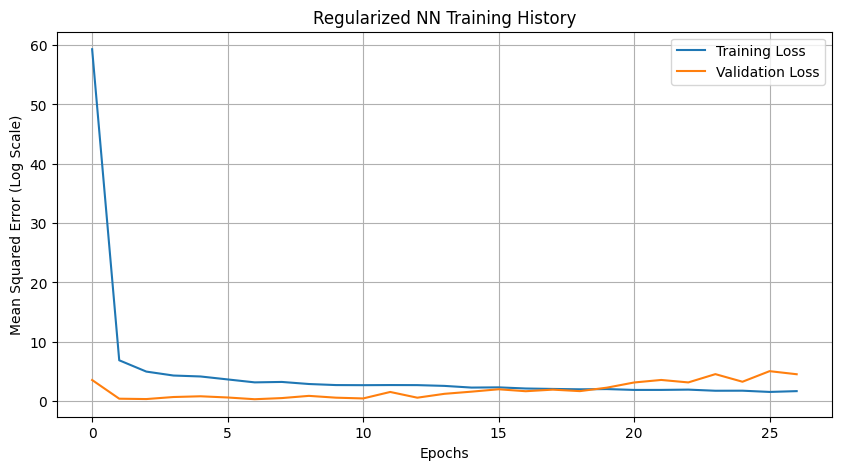

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
--- Model 3 (Regularized NN) Performance ---
R² Score:       -3.5741
RMSE (in $):    55,948,518.69


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. Define Model 3: Regularized Deep NN
print("Building Model 3: Regularized NN...")
model_3 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    # Layer 1
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Randomly drop 30% of connections

    # Layer 2
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    # Layer 3
    layers.Dense(32, activation='relu'),
    # No dropout before output usually, but we keep the network lighter here

    layers.Dense(1) # Output
])

# 2. Compile
model_3.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# 3. Define Early Stopping Callback
# Stop if validation loss doesn't improve for 20 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# 4. Train
print("Training Model 3 (with Early Stopping)...")
history_3 = model_3.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=200,          # High max epochs, early stopping will cut it short
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

# 5. Evaluate and Plot
plot_history(history_3, title="Regularized NN Training History")
r2_m3, rmse_m3 = evaluate_model(model_3, X_test, y_test, "Model 3 (Regularized NN)")

### Model 4: Robust Neural Network (Batch Normalization)
Previous experiments revealed significant instability (gradients exploding or failing to converge). To address this technical challenge, we introduce **Batch Normalization**.

Batch Normalization normalizes the inputs of each layer *during* the training process. This stabilizes the learning process, allows for higher learning rates, and often rescues models that otherwise fail to converge.

* **Architecture:** We use a wider network (256 neurons) but apply Batch Normalization and lighter Dropout (0.2) after every dense layer.

Building Model 4: Robust NN (Batch Norm)...
Training Model 4...


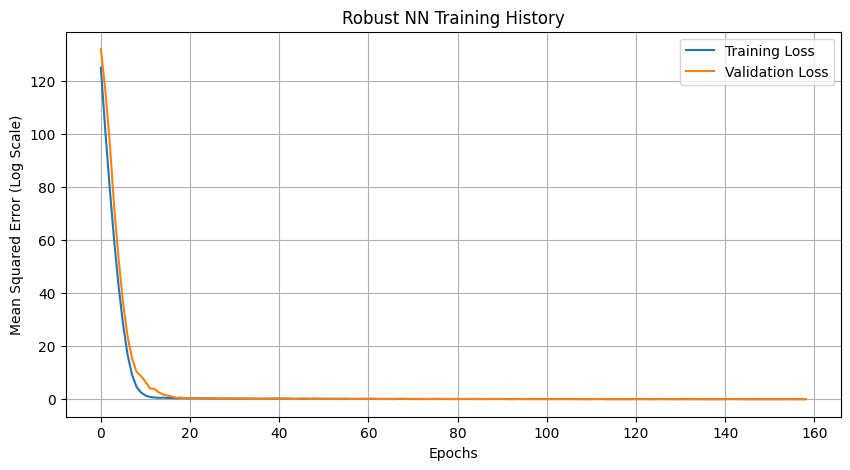

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
--- Model 4 (Robust NN) Performance ---
R² Score:       0.7239
RMSE (in $):    55,457.27


In [5]:
# 1. Define Model 4: Robust NN with Batch Normalization
print("Building Model 4: Robust NN (Batch Norm)...")
model_4 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    # Layer 1: Wider with Batch Norm
    layers.Dense(256),
    layers.BatchNormalization(), # Stabilizes learning
    layers.Activation('relu'),
    layers.Dropout(0.2),         # Reduced dropout

    # Layer 2
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),

    # Layer 3
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1) # Output
])

# 2. Compile with a specific learning rate
model_4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

# 3. Train
print("Training Model 4...")
history_4 = model_4.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

# 4. Evaluate and Plot
plot_history(history_4, title="Robust NN Training History")
r2_m4, rmse_m4 = evaluate_model(model_4, X_test, y_test, "Model 4 (Robust NN)")

## Step 3: Final Comparison & Conclusion

We now compile the results of all 5 models (1 Ensemble + 4 Neural Networks) to evaluate their performance on the unseen Test Set.

### Key Metrics:
* **$R^2$ Score:** Higher is better (1.0 is perfect). Measures how much variance the model explains.
* **RMSE ($):** Lower is better. Measures the average error in dollars.

We visualize the results to determine if the additional complexity of Deep Learning provided any benefit over the optimized Random Forest baseline.


--- Final Model Comparison ---
| Model                    |   Test R2 Score |    Test RMSE ($) |
|:-------------------------|----------------:|-----------------:|
| Optimized Random Forest  |        0.899963 |  30646.1         |
| Robust NN (Batch Norm)   |        0.72388  |  55457.3         |
| Simple NN (1 Layer)      |        0.669783 | 127144           |
| Deep NN (3 Layers)       |        0.238273 | 945035           |
| Regularized NN (Dropout) |       -3.57406  |      5.59485e+07 |


/tmp/ipython-input-3878525765.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test R2 Score', y='Model', data=comparison_df, palette='viridis')


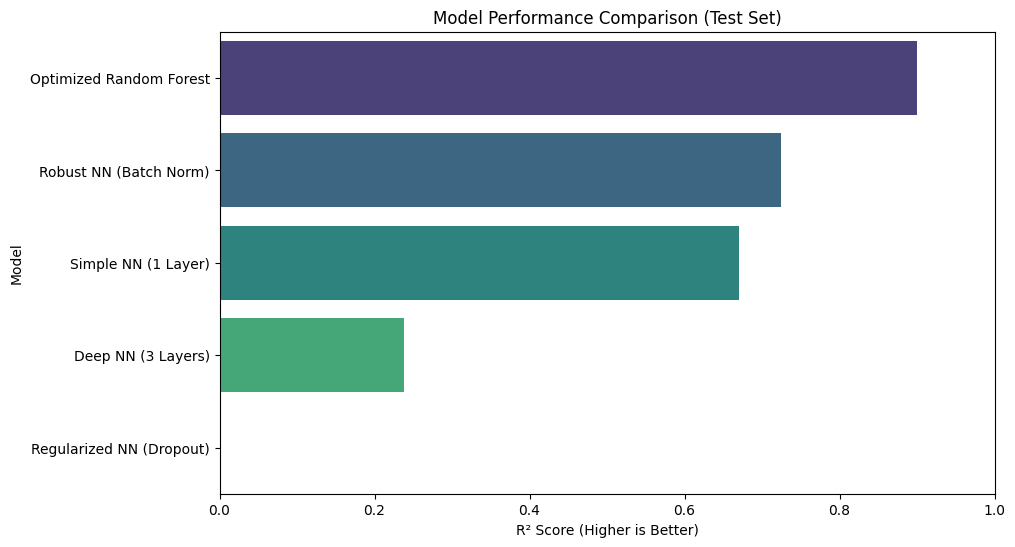

In [6]:
# 5. Final Comparison
models_data = {
    'Model': ['Optimized Random Forest', 'Simple NN (1 Layer)', 'Deep NN (3 Layers)', 'Regularized NN (Dropout)', 'Robust NN (Batch Norm)'],
    'Test R2 Score': [base_r2, r2_m1, r2_m2, r2_m3, r2_m4],
    'Test RMSE ($)': [base_rmse, rmse_m1, rmse_m2, rmse_m3, rmse_m4]
}

comparison_df = pd.DataFrame(models_data)
comparison_df = comparison_df.sort_values(by='Test R2 Score', ascending=False)

print("\n--- Final Model Comparison ---")
print(comparison_df.to_markdown(index=False))

# 6. Visualize Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Test R2 Score', y='Model', data=comparison_df, palette='viridis')
plt.title('Model Performance Comparison (Test Set)')
plt.xlabel('R² Score (Higher is Better)')
plt.xlim(0, 1.0) # Focus on positive scores
plt.show()